In [1]:
%matplotlib inline


==========================================
Outlier detection with several methods.
==========================================

When the amount of contamination is known, this example illustrates three
different ways of performing :ref:`outlier_detection`:

- based on a robust estimator of covariance, which is assuming that the
  data are Gaussian distributed and performs better than the One-Class SVM
  in that case.

- using the One-Class SVM and its ability to capture the shape of the
  data set, hence performing better when the data is strongly
  non-Gaussian, i.e. with two well-separated clusters;

- using the Isolation Forest algorithm, which is based on random forests and
  hence more adapted to large-dimensional settings, even if it performs
  quite well in the examples below.

The ground truth about inliers and outliers is given by the points colors
while the orange-filled area indicates which points are reported as inliers
by each method.

Here, we assume that we know the fraction of outliers in the datasets.
Thus rather than using the 'predict' method of the objects, we set the
threshold on the decision_function to separate out the corresponding
fraction.


Automatically created module for IPython interactive environment


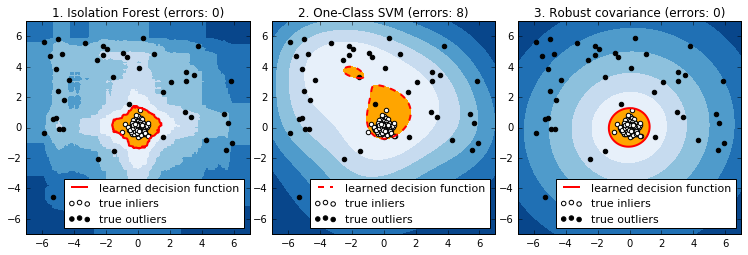

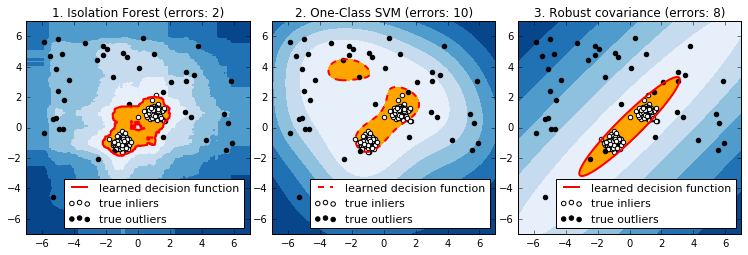

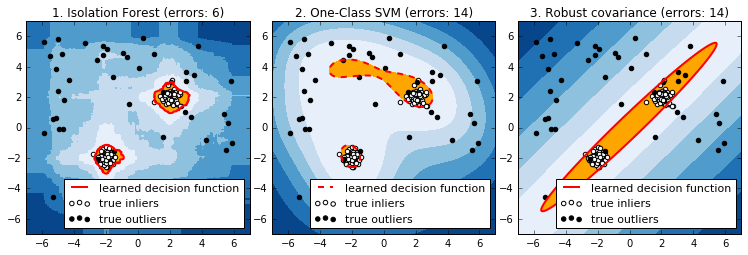

In [2]:
print(__doc__)

import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.font_manager

from sklearn import svm
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest

rng = np.random.RandomState(42)

# Example settings
n_samples = 200
outliers_fraction = 0.25
clusters_separation = [0, 1, 2]

# define two outlier detection tools to be compared
classifiers = {
    "One-Class SVM": svm.OneClassSVM(nu=0.95 * outliers_fraction + 0.05,
                                     kernel="rbf", gamma=0.1),
    "Robust covariance": EllipticEnvelope(contamination=outliers_fraction),
    "Isolation Forest": IsolationForest(max_samples=n_samples,
                                        contamination=outliers_fraction,
                                        random_state=rng)}

# Compare given classifiers under given settings
xx, yy = np.meshgrid(np.linspace(-7, 7, 500), np.linspace(-7, 7, 500))
n_inliers = int((1. - outliers_fraction) * n_samples)
n_outliers = int(outliers_fraction * n_samples)
ground_truth = np.ones(n_samples, dtype=int)
ground_truth[-n_outliers:] = -1

# Fit the problem with varying cluster separation
for i, offset in enumerate(clusters_separation):
    np.random.seed(42)
    # Data generation
    X1 = 0.3 * np.random.randn(n_inliers // 2, 2) - offset
    X2 = 0.3 * np.random.randn(n_inliers // 2, 2) + offset
    X = np.r_[X1, X2]
    # Add outliers
    X = np.r_[X, np.random.uniform(low=-6, high=6, size=(n_outliers, 2))]

    # Fit the model
    plt.figure(figsize=(10.8, 3.6))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        # fit the data and tag outliers
        clf.fit(X)
        scores_pred = clf.decision_function(X)
        threshold = stats.scoreatpercentile(scores_pred,
                                            100 * outliers_fraction)
        y_pred = clf.predict(X)
        n_errors = (y_pred != ground_truth).sum()
        # plot the levels lines and the points
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)
        subplot = plt.subplot(1, 3, i + 1)
        subplot.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),
                         cmap=plt.cm.Blues_r)
        a = subplot.contour(xx, yy, Z, levels=[threshold],
                            linewidths=2, colors='red')
        subplot.contourf(xx, yy, Z, levels=[threshold, Z.max()],
                         colors='orange')
        b = subplot.scatter(X[:-n_outliers, 0], X[:-n_outliers, 1], c='white')
        c = subplot.scatter(X[-n_outliers:, 0], X[-n_outliers:, 1], c='black')
        subplot.axis('tight')
        subplot.legend(
            [a.collections[0], b, c],
            ['learned decision function', 'true inliers', 'true outliers'],
            prop=matplotlib.font_manager.FontProperties(size=11),
            loc='lower right')
        subplot.set_title("%d. %s (errors: %d)" % (i + 1, clf_name, n_errors))
        subplot.set_xlim((-7, 7))
        subplot.set_ylim((-7, 7))
    plt.subplots_adjust(0.04, 0.1, 0.96, 0.92, 0.1, 0.26)

plt.show()